# Consumption-Saving model with housing

Here is the code that generated the results for the seminar paper: **Pandemic prices and 'Skattestop' - Houseprices and the implications for wealth inequality in Denmark**

Created by: **Magnus Ørberg** & **Matias B.F. Hall**

# Setup

Import of all relevant packages below

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#Run the following two commands in the terminal for used packages
#pip install ConSav
#pip install EconModel

import time
import numpy as np
from numba import njit, prange
from scipy import optimize

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from consav import ModelClass, jit, linear_interp, golden_section_search
from consav.misc import elapsed
    from consav.grids import nonlinspace
from consav.quadrature import log_normal_gauss_hermite

# Setting up the model

In [2]:
def settings(model):
    """ choose fundamental settings """
    
    # a. namespaces
    model.namespaces = ['par','sol','sim']
    
    # b. other attributes
    model.other_attrs = []
    
    # c. savefolder
    model.savefolder = 'saved'
    
    # b. list not-floates to safe type inferences
    model.not_floats = ['T','Nxi','Nm', 'Nh', 'Np', 'Nts', 'simN', 'shock_t', 'pens_t'] 
    # rho = 2 e.g. raises an error, while T = 2 does not


The **setup** function:

In [3]:
def setup(model):
    """ set baseline parameters (independent elements) """
        
    par = model.par

    # b. parameters
    par.T = 20 # number of periods
    par.shock_t = 8 # period when shock arriving
    par.pens_t = 14 # period of pension
    par.tau = 0.01 # Tax-rate 
    par.rho = 2.0 # CRRA parameter
    par.beta = 0.99 # discount factor
    par.theta = 0.2 # CD-parameter [from grossman]
    par.p = .0 # price of housing
    par.sigma_xi = 0.36 # std. of transitory shock
    par.Nxi  = 8 # number of quadrature points for xi
    par.R = 1.04 # return factor
    par.Nm = 100 # number of nodes in grid for m
    par.Nh = 100 # number of nodes in grid for h
    par.Np = 2 # number of nodes in grid for p
    par.Nts = 2 # number of nodes in grid for ts [tax scheme]
    par.p_min = 1.0 # minimum point in grid for p
    par.p_max = 1.065 # maximum point in grid for p
    par.p_phi = 1.0 # spacing parameter for grid for p
    par.m_min = 1e-6 # minimum point in grid for m
    par.m_max = 40.0 # maximum point in grid for m
    par.h_min = 1e-6 # minimum point in grid for h
    par.h_max = 40.0 # maximum point in grid for h
    par.m_phi = 1.3 # curvature parameter for grid for m
    par.h_phi = 1.3 # curvature parameter for grid for h
    par.simN = 5000 # number of persons in simulation
    par.wscale = 390600.0**-1 # scale intial wealth distribution (avg. post tax income)
    par.bc = 0.95 # Borrowing constraint defined as p*h/m [fraction of housing value of total wealth]

    
    

The **allocate** function:

In [4]:
def allocate(model):
    """ allocate model, i.e. create grids and allocate solution and simluation arrays (dependent elements) """
    
    par = model.par
    sol = model.sol
    sim = model.sim   
    
    # a. grids
    
    # Grids for parameters in for loops
    par.grid_m = nonlinspace(par.m_min,par.m_max,par.Nm,par.m_phi)
    par.grid_h = nonlinspace(par.h_min,par.h_max,par.Nh,par.h_phi)
    par.grid_p = np.linspace(par.p_min,par.p_max,par.Np)
    par.grid_ts = np.linspace(0,par.Nts-1,par.Nts)
    
    # nodes and weights using Gauss-Hermite
    par.xi, par.xi_w = log_normal_gauss_hermite(sigma=par.sigma_xi,n=par.Nxi) 
    
    # b. solution cond on h
    sol.c_ch = np.zeros((par.T,par.Nm,par.Nh,par.Np,par.Nts))
    sol.v_ch = np.zeros((par.T,par.Nm,par.Nh,par.Np,par.Nts))
    sol.h_ch = np.zeros((par.T,par.Nm,par.Nh,par.Np,par.Nts))
    
    # b2. solution uncond
    sol.c = np.zeros((par.T,par.Nm,par.Np,par.Nts))
    sol.v = np.zeros((par.T,par.Nm,par.Np,par.Nts))
    sol.h = np.zeros((par.T,par.Nm,par.Np,par.Nts))
    
    # c. arrays for simulation results
    sim.m = np.zeros((par.T,par.simN,par.Nts))
    sim.c = np.zeros((par.T,par.simN,par.Nts))
    sim.a = np.zeros((par.T,par.simN,par.Nts))
    sim.xi = np.zeros((par.T,par.simN,par.Nts))
    sim.h = np.zeros((par.T,par.simN,par.Nts))
    sim.ph = np.zeros((par.T,par.simN,par.Nts)) # housing times the price to get the value of housing in simulate
    

The **solve** function:

In [5]:
def value_of_choice(c,t,m,h,i_h,i_p,i_ts,ts,model):
    """ value of choice """
    par = model.par
    sol = model.sol
    
    # consumption cannot be negative
    if c <= 0: return -np.inf

    # a. end-of-period assets
    a = m - par.p*h - c
    
    # b. next-period cash-on hand [Without income]
    if ts == 0: m_plus = par.R*a + (1-par.tau)*par.p*h
    if ts == 1: m_plus = par.R*a + par.p*h - par.tau*(par.grid_p)[0]*h
    
    # c.1. On Pension
    if t >= par.pens_t: 
        v_plus = linear_interp.interp_1d(par.grid_m,sol.v_ch[t+1,:,i_h,i_p,i_ts],m_plus)
        total = (c**(1-par.theta)*h**par.theta)**(1-par.rho)/(1-par.rho) + v_plus
    
    # c.2 Not on pension [add income]
    if t < par.pens_t:
        # c. continuation value
        m_plus = m_plus + par.xi
        v_plus = np.zeros(m_plus.size)
        linear_interp.interp_1d_vec(par.grid_m,sol.v_ch[t+1,:,i_h,i_p,i_ts],m_plus,v_plus)

        # d. value-of-choice
        total = (c**(1-par.theta)*h**par.theta)**(1-par.rho)/(1-par.rho) + par.beta*np.sum(par.xi_w*v_plus)
    
    return total
    
def solve(model):
    """ solve model with vfi """
    
    par = model.par
    sol = model.sol
    
    t0 = time.time()
    
    
    # solving the value function
    for i_ts, ts in enumerate(par.grid_ts):
        for i_p,p in enumerate(par.grid_p):
            par.p = p
            for i_h,h in enumerate(par.grid_h):
                # last-period conditioned
                sol.c_ch[-1,:,i_h,i_p,i_ts] = par.grid_m*(1-par.theta)
                sol.h_ch[-1,:,i_h,i_p,i_ts] = par.grid_m*(par.theta/par.p)
                sol.v_ch[-1,:,i_h,i_p,i_ts] = (((1-par.theta)*par.grid_m)**(1-par.theta)*(par.theta*par.grid_m/par.p)**par.theta)**(1-par.rho)/(1-par.rho)
           
            # last-period unconditioned
            sol.c[-1,:,i_p,i_ts] = par.grid_m*(1-par.theta)
            sol.h[-1,:,i_p,i_ts] = par.grid_m*(par.theta/par.p)
            sol.v[-1,:,i_p,i_ts] = (((1-par.theta)*par.grid_m)**(1-par.theta)*(par.theta*par.grid_m/par.p)**par.theta)**(1-par.rho)/(1-par.rho)

            # backwards induction
            for t in reversed(range(par.T-1)):
                #Solve for a grid of m
                for i_m,m in enumerate(par.grid_m):
                    sol.v[t,i_m,i_p,i_ts] = -np.inf
                    sol.c[t,i_m,i_p,i_ts] = -np.inf
                    sol.h[t,i_m,i_p,i_ts] = -np.inf
                    #Solve first for c on a grid of h
                    for i_h,h in enumerate(par.grid_h):
                        if par.p*h/m <= par.bc: # Budget Constraint
                            obj = lambda c: -value_of_choice(c,t,m,h,i_h,i_p,i_ts,ts,model)
                            result = optimize.minimize_scalar(obj,method='bounded',bounds=(0,m))

                            sol.c_ch[t,i_m,i_h,i_p,i_ts] = result.x
                            sol.v_ch[t,i_m,i_h,i_p,i_ts] = -result.fun
                            sol.h_ch[t,i_m,i_h,i_p,i_ts] = h
                            
                        if par.p*h/m > par.bc: # Budget Constraint 
                            h = par.bc*m/par.p
                            obj = lambda c: -value_of_choice(c,t,m,h,i_h,i_p,i_ts,ts,model)
                            result = optimize.minimize_scalar(obj,method='bounded',bounds=(0,m))

                            sol.c_ch[t,i_m,i_h,i_p,i_ts] = result.x
                            sol.v_ch[t,i_m,i_h,i_p,i_ts] = -result.fun
                            sol.h_ch[t,i_m,i_h,i_p,i_ts] = h
                        
                        #Save solution if better than previous
                        if sol.v_ch[t,i_m,i_h,i_p,i_ts] > sol.v[t,i_m,i_p,i_ts]:
                            sol.v[t,i_m,i_p,i_ts] = sol.v_ch[t,i_m,i_h,i_p,i_ts]
                            sol.c[t,i_m,i_p,i_ts] = sol.c_ch[t,i_m,i_h,i_p,i_ts]
                            sol.h[t,i_m,i_p,i_ts] = sol.h_ch[t,i_m,i_h,i_p,i_ts]
                    
    
    print(f'model solved in {elapsed(t0)}')

The **simulate** function

In [6]:
def simulate(model,seed=1917):
    """ simulate model """
    
    par = model.par
    sol = model.sol
    sim = model.sim
    
    t0 = time.time()
    
    # Simulate for the two different tax-schemes
    for i_ts,ts in enumerate(par.grid_ts):

        # a. shocks
        if not seed is None: np.random.seed(seed)
        sim.xi[:,:,i_ts] = np.exp(np.random.normal(-0.5*par.sigma_xi**2,par.sigma_xi,size=(par.T,par.simN)))

        # b. initial cash-on-hand
        ## Split op in deciles and give them actual wealth.
        #for d in range(9):
        for d in range(0,10):
            for k in range(int((par.simN/10)*d),int((par.simN/10)*(d+1))):
                if d == 0: sim.m[0,k,i_ts] = 260551.8*par.wscale
                if d == 1: sim.m[0,k,i_ts] = 416538.6*par.wscale
                if d == 2: sim.m[0,k,i_ts] = 591084.7*par.wscale
                if d == 3: sim.m[0,k,i_ts] = 863124.7*par.wscale
                if d == 4: sim.m[0,k,i_ts] = 1272628.8*par.wscale
                if d == 5: sim.m[0,k,i_ts] = 1639214.8*par.wscale
                if d == 6: sim.m[0,k,i_ts] = 2095334.3*par.wscale
                if d == 7: sim.m[0,k,i_ts] = 2671087.7*par.wscale
                if d == 8: sim.m[0,k,i_ts] = 3542028.2*par.wscale
                if d == 9: sim.m[0,k,i_ts] = 7672135.4*par.wscale

        # c. time loop
        for i_p,p in enumerate(par.grid_p):
            par.p = p
            for t in range(par.shock_t*i_p,par.T*i_p+par.shock_t*(1-i_p)):
                if t >= par.pens_t: pens = 1
                if t < par.pens_t: pens = 0

                # i. consumption
                linear_interp.interp_1d_vec(par.grid_m,sol.c[t,:,i_p,i_ts],sim.m[t,:,i_ts],sim.c[t,:,i_ts])
                linear_interp.interp_1d_vec(par.grid_m,sol.h[t,:,i_p,i_ts],sim.m[t,:,i_ts],sim.h[t,:,i_ts])
                
                # ii. housing value
                sim.ph[t,:,i_ts] = p*sim.h[t,:,i_ts]

                # iii. end-of-period assets
                sim.a[t,:,i_ts] = sim.m[t,:,i_ts]-sim.c[t,:,i_ts]-(par.grid_p)[i_p]*sim.h[t,:,i_ts]

                # iv. next-period
                if ts == 0:
                    if t == par.shock_t-1: sim.m[t+1,:,i_ts] = par.R*sim.a[t,:,i_ts] + (1-par.tau)*(par.grid_p)[1]*sim.h[t,:,i_ts] + sim.xi[t+1,:,i_ts]*(1-pens) 
                    elif t < par.T-1: sim.m[t+1,:,i_ts] = par.R*sim.a[t,:,i_ts] + (1-par.tau)*par.p*sim.h[t,:,i_ts] + sim.xi[t+1,:,i_ts]*(1-pens)
                if ts == 1:
                    if t == par.shock_t-1: sim.m[t+1,:,i_ts] = par.R*sim.a[t,:,i_ts] + (par.grid_p)[1]*sim.h[t,:,i_ts] - par.tau*(par.grid_p)[0]*sim.h[t,:,i_ts] + sim.xi[t+1,:,i_ts]*(1-pens) 
                    elif t < par.T-1: sim.m[t+1,:,i_ts] = par.R*sim.a[t,:,i_ts] + par.p*sim.h[t,:,i_ts] - par.tau*(par.grid_p)[0]*sim.h[t,:,i_ts] + sim.xi[t+1,:,i_ts]*(1-pens)
            
    print(f'model simulated in {elapsed(t0)}')

# Class

**Define class:**

In [7]:
class ConsumptionSavingModelClass(ModelClass):
    
    settings = settings
    setup = setup
    allocate = allocate
    solve = solve
    simulate = simulate

**Construct instance:**

In [8]:
model = ConsumptionSavingModelClass(name='myfirstconsavmodel')

In [270]:
#print(model)

**Solve:**

In [271]:
model.solve()

model solved in 5.0 mins 16 secs


**Simulate:**

In [272]:
model.simulate()

model simulated in 0.0 secs


For easy access:

In [273]:
par = model.par
sol = model.sol
sim = model.sim

**Policy functions:**

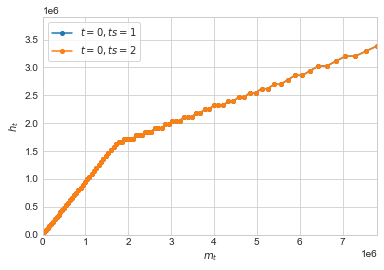

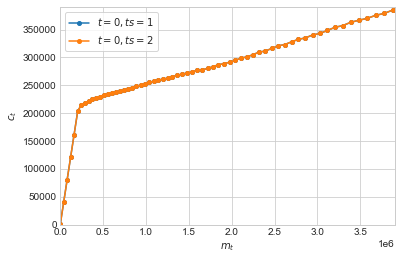

In [274]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

t = 0
ax.plot(390600*par.grid_m,390600*sol.h[t,:,0,0],'-o',ms=4,label=f'$t = {t},ts = 1$')
ax.plot(390600*par.grid_m,390600*sol.h[t,:,0,1],'-o',ms=4,label=f'$t = {t},ts = 2$')

# layout
ax.legend(frameon=True)
ax.set_xlim([0,20*390600])
ax.set_ylim([0,10*390600])
ax.set_xlabel('$m_t$')
ax.set_ylabel('$h_t$');

#plt.savefig('MPC_Ht0.png')

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(390600*par.grid_m,390600*sol.c[t,:,0,0],'-o',ms=4,label=f'$t = {t},ts = 1$')
ax.plot(390600*par.grid_m,390600*sol.c[t,:,0,1],'-o',ms=4,label=f'$t = {t},ts = 2$')

# layout
ax.legend(frameon=True)
ax.set_xlim([0,10*390600])
ax.set_ylim([0,1*390600])
ax.set_xlabel('$m_t$')
ax.set_ylabel('$c_t$');

#plt.savefig('MPCt0.png')

**Life cycle average variables:**

303210.7921402653


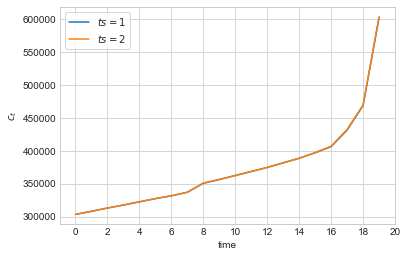

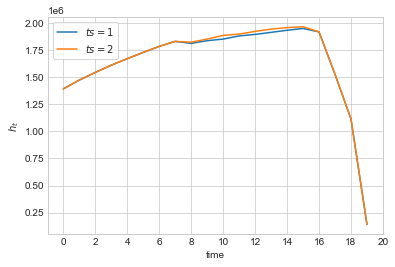

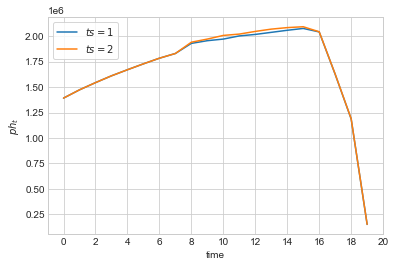

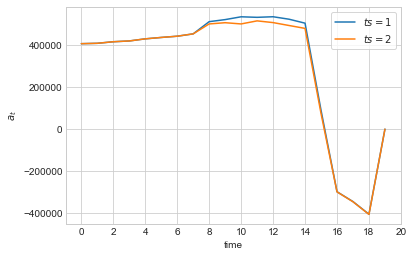

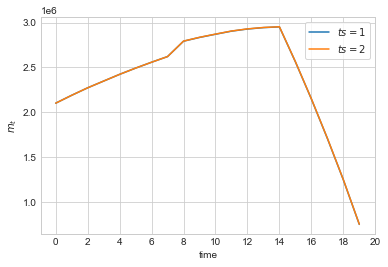

In [275]:
par = model.par
sol = model.sol

# Consumption
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(par.T),np.mean(390600*sim.c[:,:,0],axis=1),label=f'$ts = 1$')
ax.plot(np.arange(par.T),np.mean(390600*sim.c[:,:,1],axis=1),label=f'$ts = 2$')

print(np.mean(390600.0*sim.c[0,:,:]))
# layout
ax.legend(frameon=True)
plt.xticks(ticks=np.linspace(0,par.T,11))
ax.set_xlabel('time')
ax.set_ylabel('$c_t$');
plt.savefig('avgcons.png')


## Housing
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(np.arange(par.T),np.mean(390600*sim.h[:,:,0],axis=1),label=f'$ts = 1$')
ax.plot(np.arange(par.T),np.mean(390600*sim.h[:,:,1],axis=1),label=f'$ts = 2$')

# layout
plt.xticks(ticks=np.linspace(0,par.T,11))
ax.legend(frameon=True)
ax.set_xlabel('time')
ax.set_ylabel('$h_t$');
plt.savefig('avghouse.png')


## Housing times price
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(np.arange(par.T),np.mean(390600*sim.ph[:,:,0],axis=1),label=f'$ts = 1$')
ax.plot(np.arange(par.T),np.mean(390600*sim.ph[:,:,1],axis=1),label=f'$ts = 2$')

# layout
plt.xticks(ticks=np.linspace(0,par.T,11))
ax.legend(frameon=True)
ax.set_xlabel('time')
ax.set_ylabel('$ph_t$');
plt.savefig('avgphouse.png')

## Assets
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(np.arange(par.T),np.mean(390600*sim.a[:,:,0],axis=1),label=f'$ts = 1$')
ax.plot(np.arange(par.T),np.mean(390600*sim.a[:,:,1],axis=1),label=f'$ts = 2$')


# layout
plt.xticks(ticks=np.linspace(0,par.T,11))
ax.legend(frameon=True)
ax.set_xlabel('time')
ax.set_ylabel('$a_t$');
plt.savefig('avgasset.png')


# Wealth
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(np.arange(par.T),np.mean(390600*sim.m[:,:,0],axis=1),label=f'$ts = 1$')
ax.plot(np.arange(par.T),np.mean(390600*sim.m[:,:,1],axis=1),label=f'$ts = 2$')

# layout
plt.xticks(ticks=np.linspace(0,par.T,11))
ax.legend(frameon=True)
ax.set_xlabel('time')
ax.set_ylabel('$m_t$');
plt.savefig('avgwealth.png')

**Life cycle average variables separated on deciles:**

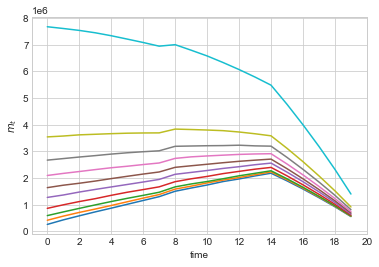

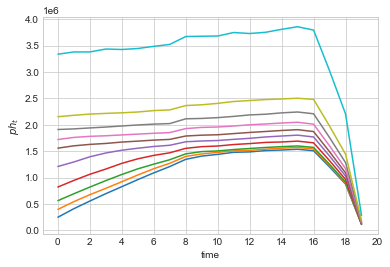

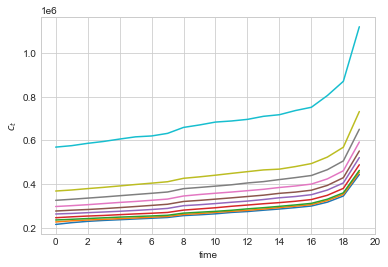

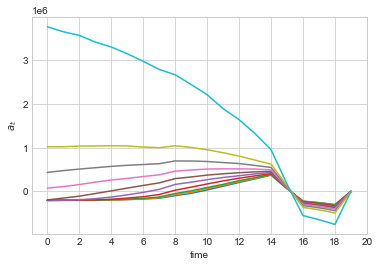

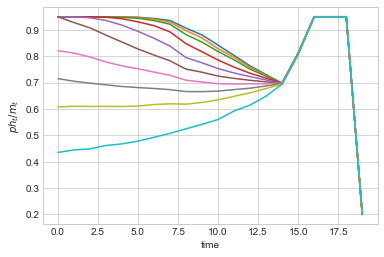

In [276]:
par = model.par
sol = model.sol


## Wealth 

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for d in range(0,10):
    ax.plot(np.arange(par.T),np.mean(sim.m[:,int((par.simN/10)*d):int((par.simN/10)*(d+1)-1),0]*par.wscale**(-1),axis=1))

# layout
plt.xticks(ticks=np.linspace(0,par.T,11))
ax.set_xlabel('time')
ax.set_ylabel('$m_t$')
plt.savefig('m_t.png');

## Housing
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for d in range(0,10):
    ax.plot(np.arange(par.T),np.mean(sim.ph[:,int((par.simN/10)*d):int((par.simN/10)*(d+1)-1),0]*par.wscale**(-1),axis=1))

# layout 
plt.xticks(ticks=np.linspace(0,par.T,11))
ax.set_xlabel('time')
ax.set_ylabel('$ph_t$');
plt.savefig('ph_t.png');

## Consumption
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for d in range(0,10):
    ax.plot(np.arange(par.T),np.mean(sim.c[:,int((par.simN/10)*d):int((par.simN/10)*(d+1)-1),0]*par.wscale**(-1),axis=1),)

# layout
plt.xticks(ticks=np.linspace(0,par.T,11))
ax.set_xlabel('time')
ax.set_ylabel('$c_t$');
plt.savefig('c_t.png');


## Assets
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for d in range(0,10):
    ax.plot(np.arange(par.T),np.mean(sim.a[:,int((par.simN/10)*d):int((par.simN/10)*(d+1)-1),0]*par.wscale**(-1),axis=1))

# layout
plt.xticks(ticks=np.linspace(0,par.T,11))
ax.set_xlabel('time')
ax.set_ylabel('$a_t$');
plt.savefig('a_t.png');





fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for d in range(0,10):
    ax.plot(np.arange(par.T),np.mean(sim.ph[:,int((par.simN/10)*d):int((par.simN/10)*(d+1)-1),0]/sim.m[:,int((par.simN/10)*d):int((par.simN/10)*(d+1)-1),0],axis=1))

# layout
ax.set_xlabel('time')
ax.set_ylabel('$ph_t/m_t$');


**Housing value over wealth**
1. Without skattestop
2. With skattestop

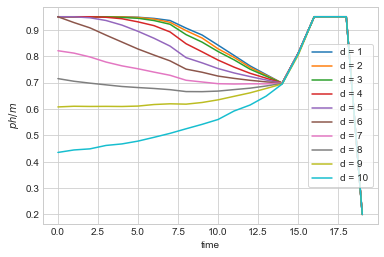

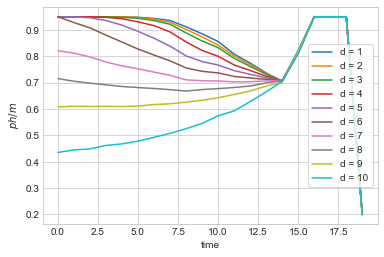

In [277]:
par = model.par
sol = model.sol

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for d in range(0,10):
    ax.plot(np.arange(par.T),np.mean(sim.ph[:,int((par.simN/10)*d):int((par.simN/10)*(d+1)-1),0]
                                     /sim.m[:,int((par.simN/10)*d):int((par.simN/10)*(d+1)-1),0],
                                     axis=1),label=f'd = {d+1}')

# layout
ax.set_xlabel('time')
ax.set_ylabel('$ph/m$')
ax.legend(frameon=True);

#With skattestop
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for d in range(0,10):
    ax.plot(np.arange(par.T),np.mean(sim.ph[:,int((par.simN/10)*d):int((par.simN/10)*(d+1)-1),1]
                                     /sim.m[:,int((par.simN/10)*d):int((par.simN/10)*(d+1)-1),1],
                                     axis=1),label=f'd = {d+1}')

# layout
ax.set_xlabel('time')
ax.set_ylabel('$ph/m$')
ax.legend(frameon=True);

**Inequality measures**

In [278]:
## d_9 share:
ts = 0
t = 8
print('d_9 t=0', 'ts=', ts,':', np.sum(sim.m[0,int((par.simN/10)*9):int((par.simN/10)*(9+1)-1),ts])/np.sum(sim.m[0,:,ts]))
print('d_9 t=',t, 'ts=', ts,':', np.sum(sim.m[t,int((par.simN/10)*9):int((par.simN/10)*(9+1)-1),ts])/np.sum(sim.m[9,:,ts]))

# d_9/d_1
print('d_9/d_1 t=0', 'ts=', ts,':', np.sum(sim.m[0,int((par.simN/10)*9):int((par.simN/10)*(9+1)-1),ts])/np.sum(sim.m[0,int((par.simN/10)*0):int((par.simN/10)*(0+1)-1),ts]))
print('d_9/d_1 t=',t, 'ts=', ts,':', np.sum(sim.m[t,int((par.simN/10)*9):int((par.simN/10)*(9+1)-1),ts])/np.sum(sim.m[t,int((par.simN/10)*0):int((par.simN/10)*(0+1)-1),ts]))

print('d_9/d_8 t=0', 'ts=', ts,':', np.sum(sim.m[0,int((par.simN/10)*9):int((par.simN/10)*(9+1)-1),ts])/np.sum(sim.m[0,int((par.simN/10)*8):int((par.simN/10)*(8+1)-1),ts]))
print('d_9/d_8 t=',t ,'ts=', ts,':', np.sum(sim.m[t,int((par.simN/10)*9):int((par.simN/10)*(9+1)-1),ts])/np.sum(sim.m[t,int((par.simN/10)*8):int((par.simN/10)*(8+1)-1),ts]))

## d_9 share:
ts = 1 
t = 8
print('d_9 t=0', 'ts=', ts,':', np.sum(sim.m[0,int((par.simN/10)*9):int((par.simN/10)*(9+1)-1),ts])/np.sum(sim.m[0,:,ts]))
print('d_9 t=',t, 'ts=', ts,':', np.sum(sim.m[t,int((par.simN/10)*9):int((par.simN/10)*(9+1)-1),ts])/np.sum(sim.m[9,:,ts]))

# d_9/d_1
print('d_9/d_1 t=0', 'ts=', ts,':', np.sum(sim.m[0,int((par.simN/10)*9):int((par.simN/10)*(9+1)-1),ts])/np.sum(sim.m[0,int((par.simN/10)*0):int((par.simN/10)*(0+1)-1),ts]))
print('d_9/d_1 t=',t ,'ts=', ts,':', np.sum(sim.m[t,int((par.simN/10)*9):int((par.simN/10)*(9+1)-1),ts])/np.sum(sim.m[t,int((par.simN/10)*0):int((par.simN/10)*(0+1)-1),ts]))

print('d_9/d_8 t=0', 'ts=', ts,':', np.sum(sim.m[0,int((par.simN/10)*9):int((par.simN/10)*(9+1)-1),ts])/np.sum(sim.m[0,int((par.simN/10)*8):int((par.simN/10)*(8+1)-1),ts]))
print('d_9/d_8 t=',t ,'ts=', ts,':', np.sum(sim.m[t,int((par.simN/10)*9):int((par.simN/10)*(9+1)-1),ts])/np.sum(sim.m[t,int((par.simN/10)*8):int((par.simN/10)*(8+1)-1),ts]))

d_9 t=0 ts= 0 : 0.36419757547293347
d_9 t= 8 ts= 0 : 0.24647285684414838
d_9/d_1 t=0 ts= 0 : 29.44572019844039
d_9/d_1 t= 8 ts= 0 : 4.653969674517708
d_9/d_8 t=0 ts= 0 : 2.166028887065327
d_9/d_8 t= 8 ts= 0 : 1.8254076771515888
d_9 t=0 ts= 1 : 0.36419757547293347
d_9 t= 8 ts= 1 : 0.24643489241714817
d_9/d_1 t=0 ts= 1 : 29.44572019844039
d_9/d_1 t= 8 ts= 1 : 4.653063066142813
d_9/d_8 t=0 ts= 1 : 2.166028887065327
d_9/d_8 t= 8 ts= 1 : 1.825298880553889


**Wealth equivalent variation**

In [282]:
# create grid for EQW
EQW = np.zeros(par.Nm)


def eq_wealth(i_m,m,model):
    """" find m_tilde as described in paper"""
    
    par = model.par
    sol = model.sol
    # get value for tax scheme 2 for given m
    v = sol.v[0,i_m,1,1]
    # find m so value function for tax scheme 1 is equal to tax scheme 2
    def obj(m_v,v,i_m, model):
        v_go = linear_interp.interp_1d(par.grid_m,sol.v[0,:,1,0],float(m_v))
        #v_go = np.interp(m_v,par.grid_m,sol.v[0,i_m,1,0])
        #v_go = m_v
        return v - v_go
    root = optimize.root(obj,x0=0.001, args=(v,i_m,model))
    # get m
    w = float(root.x)
    return w

# loop over grid of m's and solve for m_tilde
for i_m, m in enumerate(par.grid_m):
    # calculate EQW for given m's
    EQW[i_m] = eq_wealth(i_m,m,model)-m

**Deciles' EQW**

In [283]:
# create arrays for EQW for the deciles and their fractions
EQW_d = np.zeros(10)
EQW_f = np.zeros(10)
# find values
for d in range(10):
    EQW_d[d]=linear_interp.interp_1d(par.grid_m,EQW,np.mean(sim.m[0,int((par.simN/10)*d):int((par.simN/10)*(d+1)-1),0]))
    EQW_f[d] = EQW_d[d]/np.mean(sim.m[0,int((par.simN/10)*d):int((par.simN/10)*(d+1)-1),0])

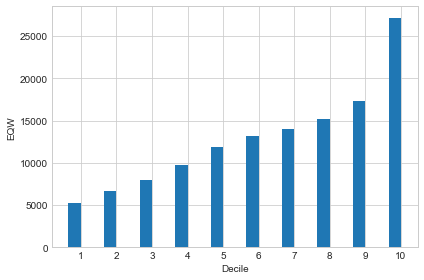

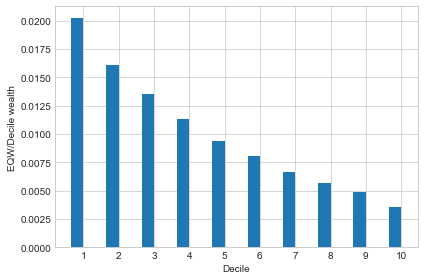

In [284]:
# Plot the EQW's

#Bin plot

width = 0.35
EQW_kr = EQW_d*390600

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, EQW_kr, width, label='ts=1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('EQW')
ax.set_xlabel('Decile')
ax.set_xticks(x)

fig.tight_layout()
plt.savefig('EQW.png')

# fractions

width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, EQW_f, width, label='ts=1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(f'EQW/Decile wealth')
ax.set_xlabel('Decile')
ax.set_xticks(x)

fig.tight_layout()
plt.savefig('EQW_f.png')


**Housing values**

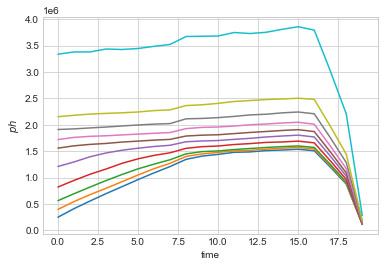

In [285]:
par = model.par
sol = model.sol

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for d in range(0,10):
    ax.plot(np.arange(par.T),np.mean(390600.0*sim.ph[:,int((par.simN/10)*d):int((par.simN/10)*(d+1)-1),0],axis=1))
# layout
ax.set_xlabel('time')
ax.set_ylabel('$ph$');